In [29]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import glob
import os
import random
print(tf.__version__)

2.6.0


In [2]:
#（不要）フォルダ内のjpgファイルを一覧表示
data_files = glob.glob("C:/Users/5010173/AI/datasets/face_AIST/**/*.jpg")
for file in data_files:
    print(file)

C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angcl_0.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angcl_left45.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angcl_left90.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angcl_right45.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angcl_right90.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angop_0.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angop_left45.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angop_left90.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angop_right45.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_angop_right90.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_discl_0.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_discl_left45.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_discl_left90.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_discl_right45.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_discl_right90.jpg
C:/Users/5010173/AI/datasets/face_AIST\f01\f01_di

In [3]:
#フォルダ内のjpgファイルを一覧表示
data_folder = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST")

all_image_paths = list(data_folder.glob('**/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

480

In [4]:
#フォルダ内のjpgファイル1つをテンソルに格納してみる

#一枚目の画像のパス
img_path = all_image_paths[0]
img_path
#生データを表示させてみる
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")
#画像のテンソルにデコード
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)
#モデルに合わせてリサイズ
img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final/255.0  #0-1に正規化
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x00\x00\x01\x00...
(800, 600, 3)
<dtype: 'uint8'>
(192, 192, 3)
0.082925715
1.0


In [5]:
#フォルダ内のjpgファイルのテンソルへのデコードの関数化
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

C:\Users\5010173\AI\datasets\face_AIST\m02\m02_angop_right45.jpg



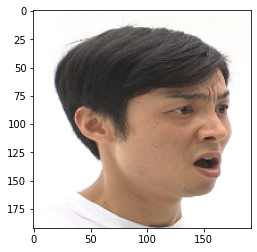

In [6]:
#テスト_後で消す

img_path = all_image_paths[0]
print(img_path)

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
print()

In [7]:
#csvファイルの中身をpythonでのコマンドライン実行で見ようとしたけど無理だった。あきらめ。
import pathlib
import subprocess

label_path = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv")
#python上でpowersellのコマンドの実行：csvファイルの中身を見る
os.system("powershell -Command Get-Date")
os.system("powershell -Command Get-Content C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv|Select-Object -first 8")

#res = subprocess.run('C:\Windows\System32\powershell.exe Get-Date', stdout=subprocess.PIPE, shell=True)
#print(res.stdout)
subprocess.Popen("powershell -Command Get-Content C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv|Select-Object -first 8",  shell=True)

<Popen: returncode: None args: 'powershell -Command Get-Content C:/Users/501...>

In [8]:
#tf.dataを用いて、csvファイルからラベルデータを作成する
label_path = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv")

#まずはtf.data.experimental.make_csv_dataset()の効果を確認してみる
def get_dataset(file_path, **kwargs):
  dataset = tf.data.experimental.make_csv_dataset(
      str(file_path),
      batch_size = 1,
      label_name='Model',
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      **kwargs)
  return dataset

raw_label_data = get_dataset(label_path)
print(type(raw_label_data))

#ラベルデータセットを確認してみる
def show_batch(dataset):
  for batch, label in dataset.take(1):
    for key, value in batch.items():
      print("{:20s}: {}".format(key,value.numpy()))

show_batch(raw_label_data)

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
﻿axis               : [b'Arousal']
FaceAngle           : [b'Right45']
Anger_cl            : [6.923077]
Anger_op            : [7.051282]
Disgust_cl          : [5.25641]
Disgust_op          : [5.6923075]
Excitement          : [6.3846154]
Fear                : [7.1282053]
Happiness           : [4.8974357]
Neutral             : [4.923077]
Relaxation          : [4.]
Sadness             : [4.6410255]
Sleepiness          : [2.3333333]
Surprise            : [8.051282]


In [30]:
#ラベルの作成

label_path = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv")
#小数点4桁まで、指数表記しない
np.set_printoptions(precision=4, suppress=True)
#csvファイルの中身をpdデータフレームに格納
df = pd.read_csv(label_path, encoding= "utf-8")

df.dtypes 

#このデータフレームを、(480,2)のラベルデータに変換しないといけない(ValenceとArousalで2個)＋画像データに合致させる

axis           object
Model          object
FaceAngle      object
Anger_cl      float64
Anger_op      float64
Disgust_cl    float64
Disgust_op    float64
Excitement    float64
Fear          float64
Happiness     float64
Neutral       float64
Relaxation    float64
Sadness       float64
Sleepiness    float64
Surprise      float64
dtype: object

In [14]:
#データフレームを活用していく
df = pd.read_csv(label_path, encoding= "utf-8")

#objectタイプをintタイプに変換
df['axis'] = pd.Categorical(df['axis'])
df['axis'] = df.axis.cat.codes
#df['axis'] = df['axis'].astype('category').cat.codes でも可
df['Model'] = pd.Categorical(df['Model'])
df['Model'] = df.Model.cat.codes
df['FaceAngle'] = pd.Categorical(df['FaceAngle'])
df['FaceAngle'] = df.FaceAngle.cat.codes

df.head()

#target = df.pop('Model')
#dataset = tf.data.Dataset.from_tensor_slices((df.values,target.values))
dataset = tf.data.Dataset.from_tensor_slices((df.values))
#作成したデータセットの確認
for item in dataset:
    print(item)


tf.Tensor(
[1.     0.     4.     3.0256 2.9744 2.7436 2.7949 6.6154 3.7436 6.5897
 5.0769 6.5641 3.2308 4.6923 4.7949], shape=(15,), dtype=float64)
tf.Tensor(
[1.     0.     3.     2.4872 2.4359 2.7436 2.3333 7.9744 2.6667 7.7436
 4.9231 7.1795 3.2564 5.     5.5897], shape=(15,), dtype=float64)
tf.Tensor(
[1.     0.     0.     2.4359 2.4872 2.641  2.2308 7.9231 2.6154 7.3077
 4.8462 6.8462 2.8462 5.1795 5.641 ], shape=(15,), dtype=float64)
tf.Tensor(
[1.     0.     1.     2.1538 2.6667 2.6923 2.1795 7.8974 2.5897 7.3333
 4.7436 6.8462 2.7436 5.0256 5.5897], shape=(15,), dtype=float64)
tf.Tensor(
[1.     0.     2.     2.6154 2.3077 2.7436 2.3333 7.7949 2.641  7.2051
 4.7179 7.0769 3.0256 5.1538 4.8205], shape=(15,), dtype=float64)
tf.Tensor(
[1.     1.     4.     3.2051 2.7692 2.4103 2.3846 6.9487 3.4359 7.6154
 6.1795 7.0769 3.1282 5.4615 4.7436], shape=(15,), dtype=float64)
tf.Tensor(
[1.     1.     3.     3.2051 2.7436 2.6667 2.2821 7.6923 3.0769 7.6923
 5.6923 7.1795 3.3077 5.5128 4

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import glob
import os
import random
import urllib
from tensorflow.keras import layers



#【フォルダ内のjpgファイルを一覧表示】
data_folder = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST")

all_image_paths = list(data_folder.glob('**/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print(image_count)

#フォルダ内のjpgファイルのテンソルへのデコードの関数化
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)



#【ラベルの読み込み】　ラベルは一つずつなのか？同時に二つは無理なのか？　→　まずは一つずつ処理する
label_path = pathlib.Path("C:/Users/5010173/AI/datasets/face_AIST/FacialExpressionDB_score.csv")
df1 = pd.read_csv(label_path, encoding= "utf-8")

#複数のインデックスを指定
df2 = df1.set_index(['axis', 'Model', 'FaceAngle'])
display(df2.head(7)) #先頭7行を表示
print(df2.columns)

#print(all_image_paths)
print(type(all_image_paths))
#all_image_paths.sort() #パスをソート
print(all_image_paths[:10])



#【画像のパスの中から、Modelと感情とFaceAngleを抽出する】
print(type(all_image_paths[0]))
print(len(all_image_paths))

all_image_paths_Model = []
all_image_paths_info = []
path_base = 'face_AIST'
path_base2 = 'jpg'

for i in range(len(all_image_paths)):
    idx = all_image_paths[i].find(path_base)
    idx2 = all_image_paths[i].find(path_base2)
    all_image_paths_Model.append(all_image_paths[i][idx+10:idx+13])
    all_image_paths_info.append(all_image_paths[i][idx+18:idx2-1])
del i,idx,idx2
#print(all_image_paths_Model[:10])
#print(all_image_paths_info[:10])

all_image_paths_FaceAngle = []
all_image_paths_Emotion = []
path_base = '_'

for i in range(len(all_image_paths)):
    idx = all_image_paths_info[i].find(path_base)
    all_image_paths_Emotion.append(all_image_paths_info[i][:idx])
    all_image_paths_FaceAngle.append(all_image_paths_info[i][idx+1:])
del i,idx

#リスト内の0をfrontに置換
#all_image_paths_FaceAngle = [s.replace('0', 'front') for s in all_image_paths_FaceAngle]
all_image_paths_FaceAngle = ['front' if s=='0' else s for s in all_image_paths_FaceAngle]

print(all_image_paths_Model[:10])
print(all_image_paths_Emotion[:10])
print(all_image_paths_FaceAngle[:10])



#感情のタグをリストとして抽出(不要コード)
Emotag = df2.columns
print(Emotag)
#【データフレームdf3の項目名を変更】
df3 = df2.rename(index = str.lower)
df3.rename(columns = {'Anger_cl':'angcl', 'Anger_op':'angop', 'Disgust_cl':'discl', \
    'Disgust_op':'disop', 'Excitement':'exc', 'Fear':'fea', 'Happiness':'hap', \
        'Neutral':'neu', 'Relaxation':'rel', 'Sadness':'sad', 'Sleepiness':'sle', \
            'Surprise':'sur'}, inplace = True) 
display(df3.head(7))



#複数インデックスのデータフレーム内の要素へのアクセスのテスト(不要コード)
print(df2.loc[('Valence','f01', 'Front'),'Anger_cl'])
#【データフレームdf3から、各画像のラベルを抽出してリストに格納】
paths_Valence = []
paths_Arousal = []
for i in range(len(all_image_paths)):
    paths_Valence.append(df3.loc[('valence',all_image_paths_Model[i], all_image_paths_FaceAngle[i]),all_image_paths_Emotion[i]])
    paths_Arousal.append(df3.loc[('arousal',all_image_paths_Model[i], all_image_paths_FaceAngle[i]),all_image_paths_Emotion[i]])
del i
print(paths_Valence[:10])
print(paths_Arousal[:10])
#このように、教師データとラベルをそれぞれ順序一致させてリストに入れれば、データセットが出来る



#【データセットの作成】
#画像のパスデータセットの作成
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
#画像のデータセットの作成
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
#ラベルデータセットの作成
label_Valence_ds = tf.data.Dataset.from_tensor_slices(tf.cast(paths_Valence, tf.int64))
label_Arousal_ds = tf.data.Dataset.from_tensor_slices(tf.cast(paths_Arousal, tf.int64))
#画像とラベルのzip化
image_label_Valence_ds = tf.data.Dataset.zip((image_ds, label_Valence_ds))
image_label_Arousal_ds = tf.data.Dataset.zip((image_ds, label_Arousal_ds))

#データセットの中身を見てみる
print(image_label_Valence_ds)
print(image_label_Arousal_ds)
for d in image_label_Valence_ds.take(3):
  print(d)



#【データセットのシャッフルとプレフェッチ】
BATCH_SIZE = 32
'''ちょっと処理が遅いらしい
# シャッフルバッファのサイズをデータセットとおなじに設定することで、データが完全にシャッフルされる
dsV = image_label_Valence_ds.shuffle(buffer_size=image_count)
dsA = image_label_Arousal_ds.shuffle(buffer_size=image_count)
dsV = dsV.repeat()
dsA = dsA.repeat()
dsV = dsV.batch(BATCH_SIZE)
dsA = dsA.batch(BATCH_SIZE)
# `prefetch`を使うことで、モデルの訓練中にバックグラウンドでデータセットがバッチを取得できます。
dsV = dsV.prefetch(buffer_size=AUTOTUNE)
dsA = dsA.prefetch(buffer_size=AUTOTUNE)
print(dsV, dsA)
'''


480


Anger_cl  Anger_op  Disgust_cl  Disgust_op  \
axis    Model FaceAngle                                               
Valence f01   Right90    3.025641  2.974359    2.743590    2.794872   
              Right45    2.487179  2.435897    2.743590    2.333333   
              Front      2.435897  2.487179    2.641026    2.230769   
              Left45     2.153846  2.666667    2.692308    2.179487   
              Left90     2.615385  2.307692    2.743590    2.333333   
        f02   Right90    3.205128  2.769231    2.410256    2.384615   
              Right45    3.205128  2.743590    2.666667    2.282051   

                         Excitement      Fear  Happiness   Neutral  \
axis    Model FaceAngle                                              
Valence f01   Right90      6.615385  3.743590   6.589744  5.076923   
              Right45      7.974359  2.666667   7.743590  4.923077   
              Front        7.923077  2.615385   7.307692  4.846154   
              Left45       7.897436  2.589744   7.333333  4.743590   
              Left90       7.794872  2.641026   7.205128  4.717949   
        f02   Right90      6.948718  3.435897   7.615385  6.179487   
              Right45      7.692308  3.076923   7.692308  5.692308   

                         Relaxation   Sadness  Sleepiness  Surprise  
axis    Model FaceAngle                                              
Valence f01   Right90      6.564103  3.230769    4.692308  4.794872  
              Right45      7.179487  3.256410    5.000000  5.589744  
              Front        6.846154  2.846154    5.179487  5.641026  
              Left45       6.846154  2.743590    5.025641  5.589744  
              Left90       7.076923  3.025641    5.153846  4.820513  
        f02   Right90      7.076923  3.128205    5.461538  4.743590  
              Right45      7.179487  3.307692    5.512821  4.794872

Index(['Anger_cl', 'Anger_op', 'Disgust_cl', 'Disgust_op', 'Excitement',
       'Fear', 'Happiness', 'Neutral', 'Relaxation', 'Sadness', 'Sleepiness',
       'Surprise'],
      dtype='object')
<class 'list'>
['C:\\Users\\5010173\\AI\\datasets\\face_AIST\\m03\\m03_angop_left45.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\f03\\f03_neu_left45.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\m03\\m03_fea_0.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\f03\\f03_fea_right45.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\f03\\f03_angop_left45.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\m02\\m02_sur_left90.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\m02\\m02_discl_left45.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\f03\\f03_exc_left45.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\f01\\f01_sad_left90.jpg', 'C:\\Users\\5010173\\AI\\datasets\\face_AIST\\f01\\f01_disop_right90.jpg']
<class 'str'>
480
['m03', 'f03', 'm03', 'f03', 'f03', 'm02', 'm02'

angcl     angop     discl     disop       exc  \
axis    Model FaceAngle                                                     
valence f01   right90    3.025641  2.974359  2.743590  2.794872  6.615385   
              right45    2.487179  2.435897  2.743590  2.333333  7.974359   
              front      2.435897  2.487179  2.641026  2.230769  7.923077   
              left45     2.153846  2.666667  2.692308  2.179487  7.897436   
              left90     2.615385  2.307692  2.743590  2.333333  7.794872   
        f02   right90    3.205128  2.769231  2.410256  2.384615  6.948718   
              right45    3.205128  2.743590  2.666667  2.282051  7.692308   

                              fea       hap       neu       rel       sad  \
axis    Model FaceAngle                                                     
valence f01   right90    3.743590  6.589744  5.076923  6.564103  3.230769   
              right45    2.666667  7.743590  4.923077  7.179487  3.256410   
              front      2.615385  7.307692  4.846154  6.846154  2.846154   
              left45     2.589744  7.333333  4.743590  6.846154  2.743590   
              left90     2.641026  7.205128  4.717949  7.076923  3.025641   
        f02   right90    3.435897  7.615385  6.179487  7.076923  3.128205   
              right45    3.076923  7.692308  5.692308  7.179487  3.307692   

                              sle       sur  
axis    Model FaceAngle                      
valence f01   right90    4.692308  4.794872  
              right45    5.000000  5.589744  
              front      5.179487  5.641026  
              left45     5.025641  5.589744  
              left90     5.153846  4.820513  
        f02   right90    5.461538  4.743590  
              right45    5.512821  4.794872

2.435897436
[2.41025641, 4.794871795, 3.538461538, 3.564102564, 2.487179487, 5.025641026, 2.487179487, 7.461538462, 3.025641026, 2.794871795]
[6.974358974, 4.897435897, 7.384615385, 7.538461538, 6.974358974, 8.102564103, 5.384615385, 6.948717949, 3.948717949, 5.641025641]
<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>
<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>
(<tf.Tensor: shape=(192, 192, 3), dtype=float32, numpy=
array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
       

'ちょっと処理が遅いらしい\n# シャッフルバッファのサイズをデータセットとおなじに設定することで、データが完全にシャッフルされる\ndsV = image_label_Valence_ds.shuffle(buffer_size=image_count)\ndsA = image_label_Arousal_ds.shuffle(buffer_size=image_count)\ndsV = dsV.repeat()\ndsA = dsA.repeat()\ndsV = dsV.batch(BATCH_SIZE)\ndsA = dsA.batch(BATCH_SIZE)\n# `prefetch`を使うことで、モデルの訓練中にバックグラウンドでデータセットがバッチを取得できます。\ndsV = dsV.prefetch(buffer_size=AUTOTUNE)\ndsA = dsA.prefetch(buffer_size=AUTOTUNE)\nprint(dsV, dsA)\n'

In [7]:
print('datasetサイズ=' + str(len(image_label_Valence_ds))+ ', ' + str(len(image_label_Arousal_ds)))

#【データセットのシャッフルとプレフェッチ】
BATCH_SIZE = 32
dsV = image_label_Valence_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
dsV = dsV.batch(BATCH_SIZE)
dsV = dsV.prefetch(buffer_size=AUTOTUNE)
dsA = image_label_Arousal_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
dsA = dsA.batch(BATCH_SIZE)
dsA = dsA.prefetch(buffer_size=AUTOTUNE)



#【データセットの分割】
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

(train_dsV, val_dsV, test_dsV) = get_dataset_partitions_tf(dsV, 580)
print(train_dsV)



#【モデルの構築】


datasetサイズ=480, 480
<TakeDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>


In [ ]:
#データセットdsAとdsAを作った後のコードだけど、うまくいかない。

#【MobileNetV2で転移学習させるために読み込み（プロキシ通してから）】
proxy = urllib.request.ProxyHandler({'http': 'http://proxy.apo.epson.net:8080'}) 		
proxy = urllib.request.ProxyHandler({'https': 'http://proxy.apo.epson.net:8080'}) 		
opener = urllib.request.build_opener(proxy) 		
urllib.request.install_opener(opener)		

mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

#データをMobileNetに渡す前に入力を[-1, 1]の範囲に変換
def change_range(image,label):
    return 2*image-1, label
keras_dsV = dsV.map(change_range)
keras_dsA = dsA.map(change_range)

#バッチを１つ渡してみる（不要なコード）
image_batch_V, label_batch_V = next(iter(keras_dsV))
feature_map_batch_V = mobile_net(image_batch_V)
print(feature_map_batch_V.shape)
image_batch_A, label_batch_A = next(iter(keras_dsA))
feature_map_batch_A = mobile_net(image_batch_A)
print(feature_map_batch_A.shape)



#【モデルの構築：これは画像起点の回帰問題？（指標化）】
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1)])

logit_batch_V = model(image_batch_V).numpy()
print("min logit:", logit_batch_V.min())
print("max logit:", logit_batch_V.max())
print("Shape:", logit_batch_V.shape)

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

model.fit(dsV, epochs=1, steps_per_epoch=3)